In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import random

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv('../data/processed_data/merged_characteristics.csv')

########create mkt share data for logit
logit_keys = ['market_ids', 'product_ids', 'firm_ids', 'shares', 'prices', 'demand_instruments0']
nonlinear_cols = ['EHBPercentTotalPremium']
linear_cols = [ 'act_value','MetalLevel_Platinum', 'MetalLevel_Silver','Plan Counts']
mkt_cols = [ 'DP05_0015PE' ,'DP05_0069PE','S1701_C01_017E','StateCodeFL'] 
firm_cols =  linear_cols+ nonlinear_cols   
logit_x_cols = firm_cols + mkt_cols + ['DP03_0095E']


############keys for boosted trees...
keys = ['HIOS ID', 'IssuerId', 'County', 'State', 'FIPS County Code', 'Policy County FIPS Code','County Name']
missing_cols = ['DP05_0028PE', 'Number of Consumers with CSR AV of 87%', 
                'Average Monthly Advanced CSR Payment for Consumers with 87%', 
                'DP05_0018PE', 'Number of Consumers with CSR (AV of 73%/87%/94%)', 'Total Number of Consumers',
                'Number of Consumers with CSR AV of 73%', 'Number of Consumers with CSR AV of 94%','FIPS County Code',
                'Average Monthly Advanced CSR Payment for Consumers with 73%', 
                'Average Monthly Advanced CSR Payment for Consumers with 94%', 
                'DP05_0032PE', 'DP05_0004PE', 'County Name']

#setup y
y_cols = ['Ever Enrolled Count']
keys = ['HIOS ID', 'IssuerId', 'County', 'State', 'FIPS County Code', 'Policy County FIPS Code','County Name']

In [3]:
def create_logit_data(df):
    df = df.copy()
    
    #create market data...
    df['shares'] = df['Ever Enrolled Count']/df['DP03_0095E']
    #add logit columns
    df['product_ids'] = df['IssuerId'].astype(str) +  df['County'].astype(str) 

    #demand_instrument0
    MktIds = np.array(pd.get_dummies(df['IssuerId']))
    MktIds2 = (MktIds.T).dot(MktIds)
    dummies_proj = MktIds.dot( np.linalg.inv( MktIds2 ) ).dot( MktIds.T )
    df['demand_instruments0'] = dummies_proj.dot(df['PREMI27']) #average price across markets

   
    #fix problematic columns
    df = df.rename(columns={'Average Monthly Advanced CSR Payment for Consumers with 94%':'csr_pay_94',
                      'Average Monthly Advanced CSR Payment for Consumers with 87%':'csr_pay_87',
                           'Total Number of Consumers':'csr_tot',
                            'Number of Consumers with CSR AV of 94%':'csr_tot_94'
                           ,'PREMI27':'prices', 'County':'market_ids', 'IssuerId':'firm_ids'})
    
    #standardize the cols
    for col in firm_cols:
        df[col] = df[col]/df[col].std()
    df = df[df['shares']!=0]
    
    
    ######### preprocess lasso data
    lasso_x_cols = ['prices']

    for col in df.columns:
        if (col not in y_cols and col not in keys and col not in missing_cols 
            and not 'StateCode' in col and not 'IssuerId' in col and 'csr_' not in col
            and col not in logit_keys and col not in logit_x_cols):
                df[col] = df[col]/df[col].std()
                lasso_x_cols.append(col) 
    
    df = df.fillna(0)
    
    all_cols = list(set(logit_keys + logit_x_cols + y_cols+lasso_x_cols+logit_x_cols))
    clean_df = df[all_cols]
    return sm.add_constant(clean_df),lasso_x_cols


clean_df,lasso_x_cols = create_logit_data(df)

print(clean_df['prices'].mean()),#(1-clean_df['shares'].mean()))
print(clean_df['Ever Enrolled Count'].sum())
print( (clean_df['shares']*clean_df['DP03_0095E']).sum() )

142.14997349144596
9870266.0
9870266.0


/home/erichschulman/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [4]:
num_trials = 5
training_test = []

#initilize folds
np.random.seed()
kf = KFold(n_splits=num_trials,shuffle=True)
folds_indexes = kf.split(clean_df)

for fold_index in folds_indexes:
    np.random.seed()
    X_train = clean_df.iloc[fold_index[0]]
    X_test = clean_df.iloc[fold_index[1]]
    training_test.append( (X_train, X_test) )

In [5]:
mses = []
r2s = []
model_fit = None
pred_shares = None
true_shares = None
blp_pred = None

for i in range(num_trials):
    X_train, X_test = training_test[i]
    x_cols = logit_x_cols+['const','demand_instruments0']
    y_cols = ['shares']
    model_fit = sm.Logit(X_train[y_cols], X_train[x_cols]).fit(disp=0)
    pred_shares = model_fit.predict(X_test[x_cols])
    
    #make predictions/figure out error
    blp_pred = pred_shares*X_test['DP03_0095E']
    true_shares = X_test['shares']*X_test['DP03_0095E']
    error = blp_pred - true_shares
    
    mse = float( (error**2).mean() )
    r2 = float( 1 - mse/true_shares.var() ) 
    mses.append(mse)
    r2s.append(r2)
    print('------------------')
    print('mse normalized trial ', i,': r2', r2)
    print('training', (X_train['shares']*X_train['DP03_0095E']).mean() ,
          'predicted share', blp_pred.mean() ,'actual', true_shares.mean())
    print('------------------')
    
mses,r2s = np.array(mses),np.array(r2s)
enrollments = clean_df['shares']*clean_df['DP03_0095E']
print( 'mse', np.array(mses).mean() ,'r2', 1 - float( mses.mean()/enrollments.var()) )
print( 'mse med', np.median(mses) ,'r2 med',r2s.reshape(num_trials,1)[mses == np.median(mses)][0,0] )

------------------
mse normalized trial  0 : r2 0.0577769050472291
training 1234.398877280524 predicted share 1187.0001810890872 actual 1218.2456359102243
------------------
------------------
mse normalized trial  1 : r2 0.18681456728120893
training 1234.3531888351786 predicted share 1170.4488285070727 actual 1218.4283042394015
------------------
------------------
mse normalized trial  2 : r2 0.25931086630161704
training 1213.6390707826629 predicted share 1197.7420941172018 actual 1301.30068621335
------------------
------------------
mse normalized trial  3 : r2 -0.09850686252636542
training 1196.7634861241036 predicted share 1426.3907905380977 actual 1368.8240798502807
------------------
------------------
mse normalized trial  4 : r2 0.08350442126323121
training 1276.6814780168381 predicted share 1250.5047716033391 actual 1049.0524017467249
------------------
mse 21469904.286188044 r2 0.1342536207035241
mse med 22652077.832286343 r2 med 0.18681456728120893


/home/erichschulman/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:3500: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


                           Logit Regression Results                           
Dep. Variable:                 shares   No. Observations:                 6414
Model:                          Logit   Df Residuals:                     6402
Method:                           MLE   Df Model:                           11
Date:                Tue, 17 May 2022   Pseudo R-squ.:                     inf
Time:                        10:38:10   Log-Likelihood:                -99.811
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
act_value                  0.1247      0.384      0.324      0.746      -0.629       0.878
MetalLevel_Platinum        0.0302      0.113      0.266      0.790      -0.192       0.253
Meta

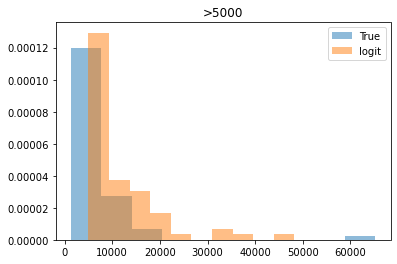

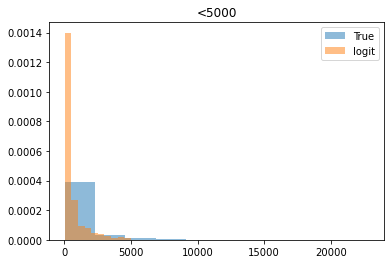

In [6]:
#print fit
print(model_fit.summary())

#evaluating model fit...
blp_pred = pred_shares*X_test['DP03_0095E']
true_shares = X_test['shares']*X_test['DP03_0095E']

split = 5000
plt.title('>'+str(split))
plt.hist(blp_pred[true_shares >=split],label='True',alpha=.5,density=True)
plt.hist(true_shares[true_shares >=split],label='logit',alpha = .5,density=True)
plt.legend()
plt.show()


plt.title('<'+str(split))
plt.hist(blp_pred[true_shares <=split],label='True',alpha=.5,density=True)
plt.hist(true_shares[true_shares <=split],label='logit',alpha = .5,density=True)
plt.legend()
plt.show()

In [7]:
def report_error(X_test,pred_shares):
    pred_shares = np.array(pred_shares.copy())
    X_test = X_test.copy()
    X_test['error'] =  ((X_test['shares']- pred_shares)*X_test['DP03_0095E'])**2
    X_test['pred'] = pred_shares*X_test['DP03_0095E']
    result = X_test.merge(df, how='inner',left_index=True, right_index=True,suffixes=('_x',''))    
    result = result.sort_values('error',ascending=False).head(50) 

    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count','prices']].mean()
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count']].mean()
    result_groupby[['pred_var','enroll_var']] = result.groupby('State')[['pred','Ever Enrolled Count']].std()
    result_groupby['count'] =result.groupby('State')['shares'].count()
    result_groupby = result_groupby.sort_values('pred',ascending=False)
    return result_groupby

print(report_error(X_test,pred_shares))

               pred  Ever Enrolled Count      pred_var    enroll_var  count
State                                                                      
FL     17229.410707          6153.800000  17814.577844   6159.850409     10
PA      8661.697011         20785.000000    606.505250   5164.707930      2
MI      8369.403341          3909.200000   1395.077660   6928.198518      5
AZ      7493.958893           164.000000           NaN           NaN      1
UT      7434.153261          1213.000000           NaN           NaN      1
TX      7120.426648          9694.800000   1407.675576  13814.990018      5
OH      6999.886711           167.600000   1474.788592    113.379010      5
NJ      6918.300752          7339.400000   1207.616990   8355.891502      5
VA      6839.495274         32449.000000           NaN           NaN      1
IL      6263.000077         22455.000000   3919.478435  19128.652645      2
WI      5971.954632           702.000000           NaN           NaN      1
GA      5951